In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<blockquote>Read Data:</blockquote>

In [2]:
df = pd.read_csv("./data/train.csv")

<blockquote>Data Exploration:</blockquote>

In [3]:
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


In [4]:
# Split the 'week' column
df[['day', 'month', 'year']] = df['week'].str.split('/', expand=True)

# Convert 'year' to full 4-digit year
df['year'] = df['year'].apply(lambda x: int(x) + 2000 if int(x) < 100 else int(x))

In [5]:
df.drop(columns=["record_ID",'week'], inplace=True)

In [6]:
df.describe()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year
count,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206,2011.830769
std,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904,0.755887
min,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000,2011.000000
25%,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000,2011.000000
50%,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000,2012.000000
75%,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000,2012.000000
max,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000,2013.000000


In [7]:
'''Observations:
1. 'store_id' and 'sku_id' are not features which can be used directly since they are identifier for each store and SKU
2. 'units_sold' has high outliers and can affect modelling if not handled
'''

"Observations:\n1. 'store_id' and 'sku_id' are not features which can be used directly since they are identifier for each store and SKU\n2. 'units_sold' has high outliers and can affect modelling if not handled\n"

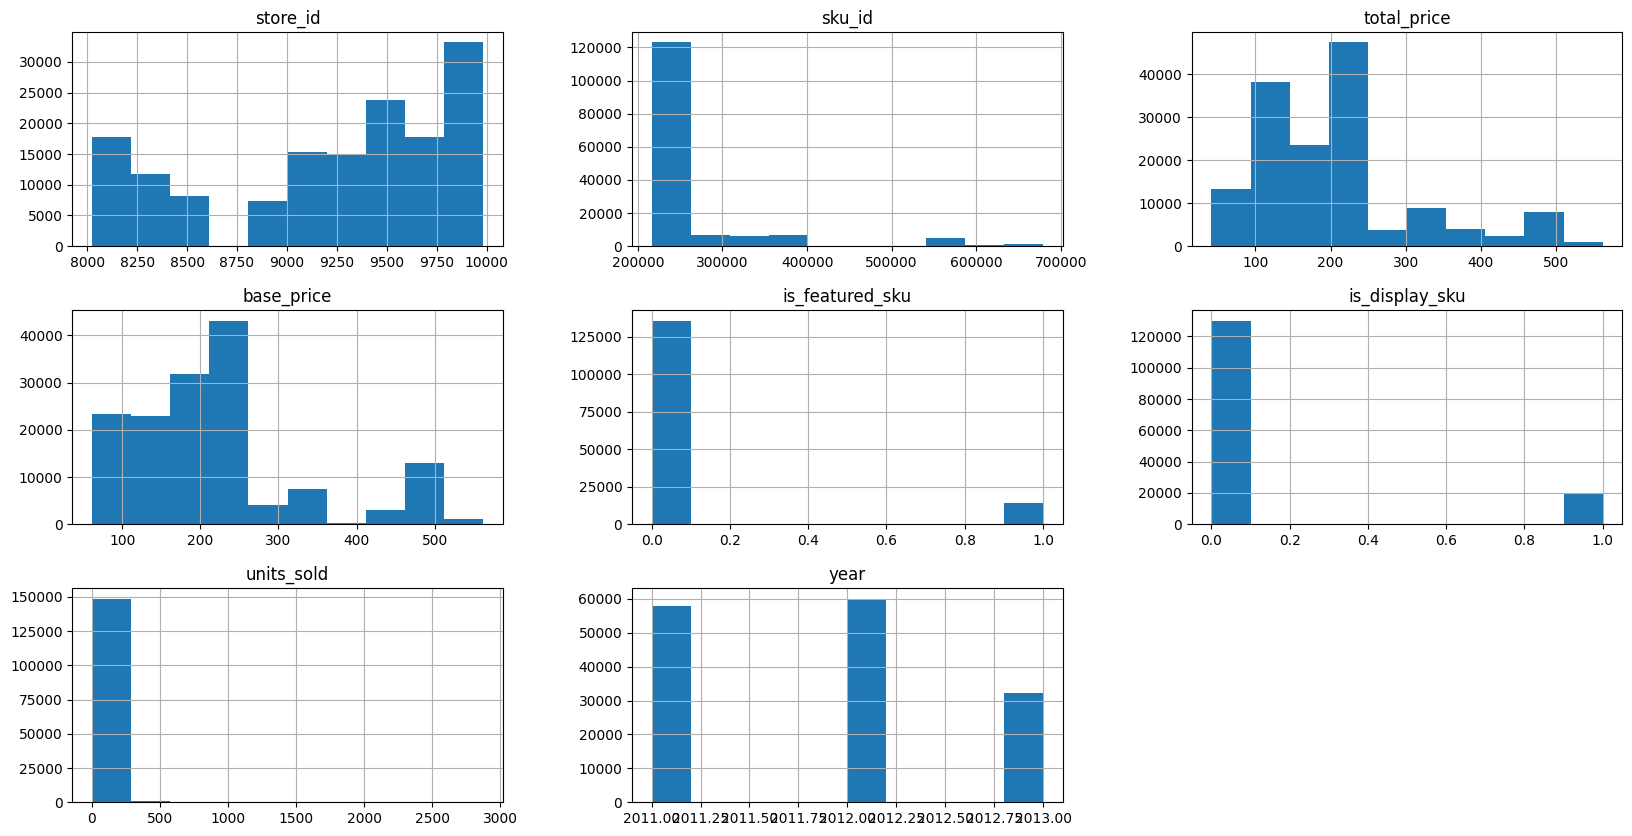

In [8]:
df.hist(figsize=(20,10));

In [9]:
def visualize_dataframe(df):
    
    # Determine data types
    numeric_cols = df.select_dtypes(include='number').columns
    categorical_cols = df.select_dtypes(include='object').columns
    datetime_cols = df.select_dtypes(include='datetime').columns
    
    # Plot numeric columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plot categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 5))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Value counts of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    # Plot time series if datetime columns exist
    if len(datetime_cols) > 0 and len(numeric_cols) > 0:
        for dt_col in datetime_cols:
            for num_col in numeric_cols:
                plt.figure(figsize=(10, 5))
                df_sorted = df.sort_values(by=dt_col)
                plt.plot(df_sorted[dt_col], df_sorted[num_col], marker='o')
                plt.title(f'{num_col} over time ({dt_col})')
                plt.xlabel(dt_col)
                plt.ylabel(num_col)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

In [10]:
df.columns

Index(['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'units_sold', 'day', 'month', 'year'],
      dtype='object')

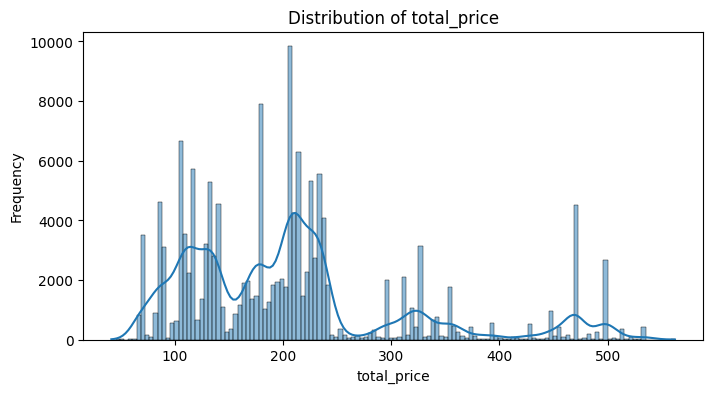

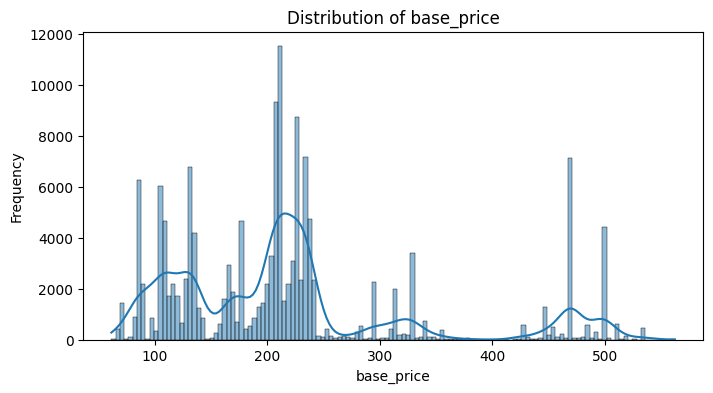

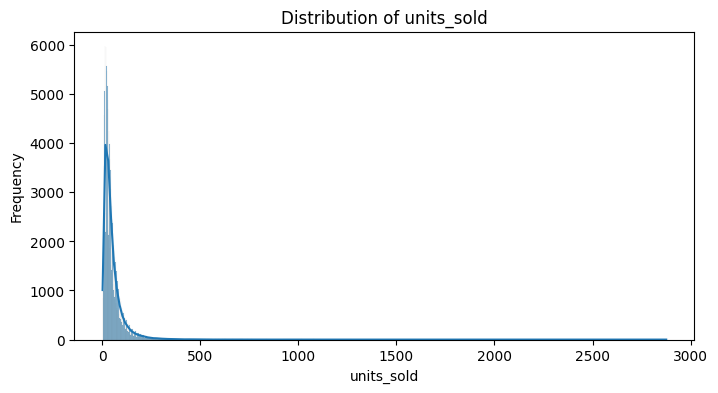

In [11]:
skip_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'day', 'month', 'year']
visualize_dataframe(df.drop(columns=skip_cols))

<blockquote>Data Cleaning:</blockquote>

In [12]:
df.isna().sum()

store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
day                0
month              0
year               0
dtype: int64

In [13]:
df = df.dropna()
df = df.reset_index(drop=True)

<blockquote>Training Baseline Model:</blockquote>

In [14]:
X, y = df.drop(columns='units_sold'), df['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
model = RandomForestRegressor(n_jobs=-1, random_state=33)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=33)

In [16]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse

30.683471831748175

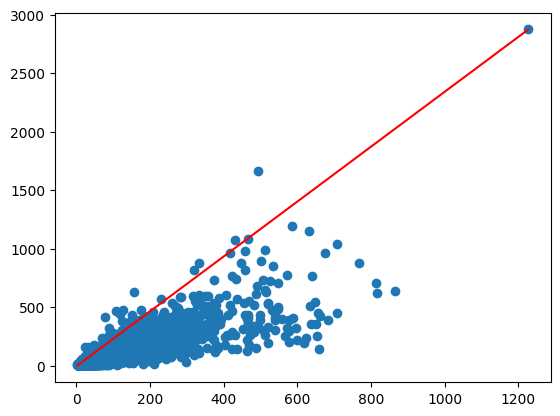

In [17]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='red');

<blockquote>Feature Engineering:</blockquote>

In [18]:
Q1 = np.percentile(df['units_sold'], 25)
Q3 = np.percentile(df['units_sold'], 75)

# Calculate IQR
IQR = Q3 - Q1

# Define thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

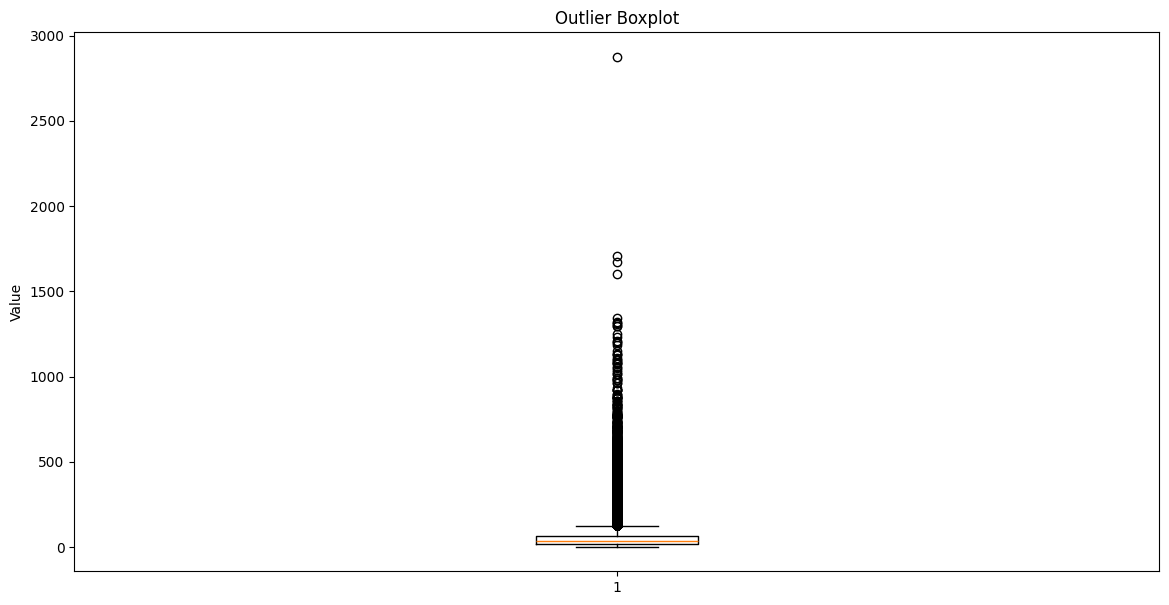

In [19]:
plt.figure(figsize=(14, 7))
plt.boxplot(df['units_sold'])
plt.title('Outlier Boxplot')
plt.ylabel('Value')
plt.show()

In [20]:
df = df[df['units_sold'] < df['units_sold'].quantile(0.99)]

In [21]:
seasonality = df.groupby(['year', 'month'])['units_sold'].sum().reset_index()

# Create a proper 'year-month' column (e.g., '2025-05')
seasonality['year-month'] = seasonality['year'].astype(str) + '-' + seasonality['month'].astype(str).str.zfill(2)

In [22]:
# Consider only 2 years of data to compute seasonality
seasonality = seasonality[seasonality['year']<2013]

In [23]:
season = seasonality.groupby(by='month')[['units_sold']].sum().reset_index()
season = season.sort_values(by='units_sold').reset_index().drop(columns='index')
monthly_rank = dict()
for i in range(12):
    monthly_rank[season['month'].iloc[i]] = i+1
df['seasonality'] = df['month'].map(monthly_rank)

In [24]:
df = df.reset_index(drop=True)

In [25]:
# Apply OHE on 'store_id' & 'sku_id'
df = df.join(pd.get_dummies(df['store_id'], prefix='store')).drop(columns='store_id')
df = df.join(pd.get_dummies(df['sku_id'], prefix='item')).drop(columns='sku_id')

In [26]:
X, y = df.drop(columns='units_sold'), df['units_sold']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_jobs=-1, random_state=33)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=33)

In [28]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse

17.8688040127847

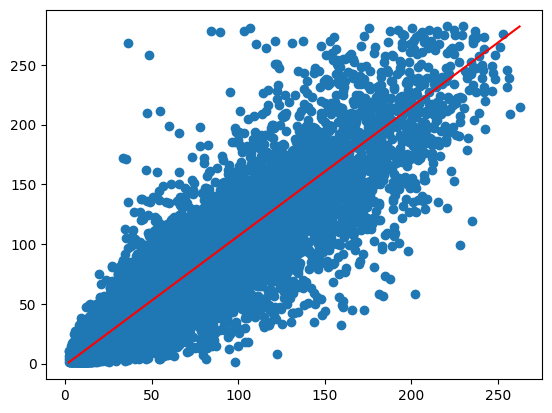

In [29]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='red');

<blockquote>Hyperparameter Tuning:</blockquote>

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[100, 120, 130],
    'max_depth':[5, 10, 20]
}

In [31]:
model = RandomForestRegressor(n_jobs=-1)
CV = GridSearchCV(model, param_grid, verbose=True, cv=3)

In [32]:
CV.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [100, 120, 130]},
             verbose=True)

In [33]:
CV.best_params_

{'max_depth': 20, 'n_estimators': 130}

In [34]:
y_pred = CV.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse

21.718225729952547